In [10]:
import torch
from torch import nn

import math
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(111)

In [7]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [15]:
train_set[:4]

[(tensor([0.3957, 0.3854]), tensor(0.)),
 (tensor([1.3985, 0.9852]), tensor(0.)),
 (tensor([2.6612, 0.4621]), tensor(0.)),
 (tensor([2.3004, 0.7454]), tensor(0.))]

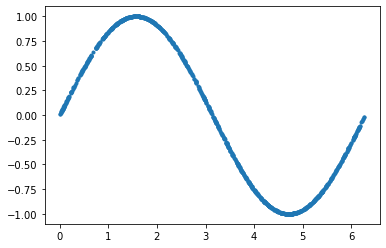

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [19]:
# (256, 128, 64, 1)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

# (16, 32, 2)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [82]:
discriminator = Discriminator()
generator = Generator()

lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss() # binary cross entropy

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

# 1st loop: epochs; 2nd loop: batches of each epoch

gan_probs = []
gan_loss = []
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 23 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} \tLoss D.: {loss_discriminator} Loss G.: {loss_generator}")
        if n == batch_size-1:
            l = np.log(1 - output_discriminator_generated.detach()).mean()
            gan_probs.append(output_discriminator_generated.mean().detach())
            gan_loss.append(l)

Epoch: 0 	Loss D.: 0.19425833225250244 Loss G.: 2.0291712284088135
Epoch: 23 	Loss D.: 0.6190754771232605 Loss G.: 0.8936962485313416
Epoch: 46 	Loss D.: 0.680740237236023 Loss G.: 0.84113609790802
Epoch: 69 	Loss D.: 0.700116753578186 Loss G.: 0.6385335326194763
Epoch: 92 	Loss D.: 0.6599435806274414 Loss G.: 0.7933101654052734
Epoch: 115 	Loss D.: 0.6966652870178223 Loss G.: 0.6752187013626099
Epoch: 138 	Loss D.: 0.6996221542358398 Loss G.: 0.7056834697723389
Epoch: 161 	Loss D.: 0.6962684988975525 Loss G.: 0.674151599407196
Epoch: 184 	Loss D.: 0.6099556684494019 Loss G.: 1.0857125520706177
Epoch: 207 	Loss D.: 0.6727581024169922 Loss G.: 0.7350782752037048
Epoch: 230 	Loss D.: 0.687620222568512 Loss G.: 0.7034450173377991
Epoch: 253 	Loss D.: 0.6918469667434692 Loss G.: 0.6801425218582153
Epoch: 276 	Loss D.: 0.6852702498435974 Loss G.: 0.6956573128700256
Epoch: 299 	Loss D.: 0.6197686195373535 Loss G.: 0.6908825635910034


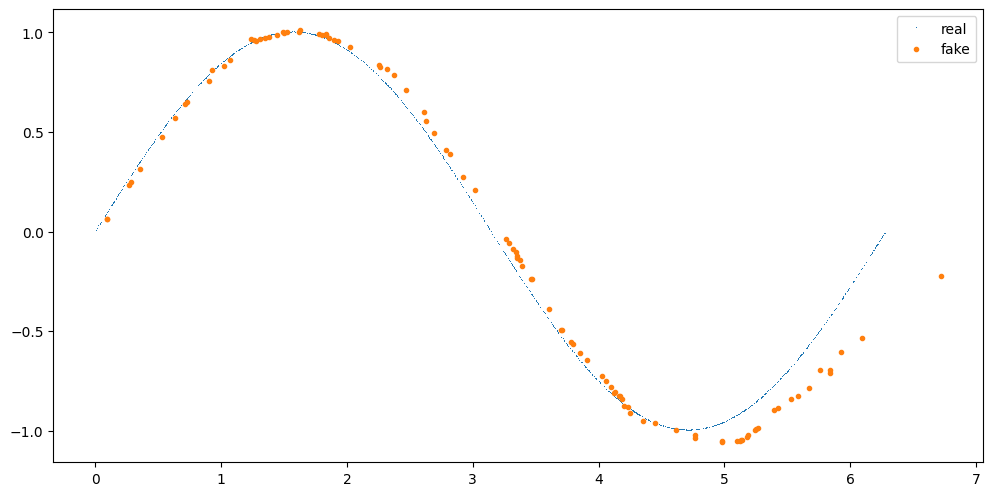

In [61]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data[:, 0], train_data[:, 1], ',')
plt.plot(generated_samples.detach()[:, 0], generated_samples.detach()[:, 1], '.')
plt.legend(['real', 'fake'])

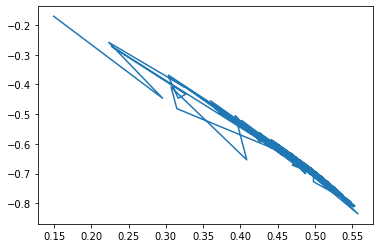

In [85]:
plt.plot(gan_probs, gan_loss, '-')